<a href="https://colab.research.google.com/github/KelvinLam05/customer_e-mail_categorization/blob/main/e-commerce_customer_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal of the project**


Companies put a lot of emphasis on customer acquisition, and rightfully so: companies need customers. However, customer acquisition costs are usually fairly high, and companies sometimes focus too much on acquisition and not enough on retention. A company may have great acquisition rates, but, if you also have a high churn rate, we are essentially flushing those acquisition costs down the drain. The goal of this project is to demonstrate how machine learning can be used to identify customers who are likely to churn. If customers at high risk of churn can be identified early, interventions can be done to retain that customer.

In [234]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

**Load the data**

In [235]:
# Load dataset
df = pd.read_excel('/content/e-commerce_dataset.xlsx')

In [236]:
# Rename Pandas columns to lower case
df.columns = df.columns.str.lower()

In [237]:
df = df.applymap(lambda s: s.lower() if type(s) == str else s)

In [238]:
# Examine the data
df.head()

,customerid,churn,tenure,preferredlogindevice,citytier,warehousetohome,preferredpaymentmode,gender,hourspendonapp,numberofdeviceregistered,preferedordercat,satisfactionscore,maritalstatus,numberofaddress,complain,orderamounthikefromlastyear,couponused,ordercount,daysincelastorder,cashbackamount
0,50001,1,4.0,mobile phone,3,6.0,debit card,female,3.0,3,laptop & accessory,2,single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,phone,1,8.0,upi,male,3.0,4,mobile,3,single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,phone,1,30.0,debit card,male,2.0,4,mobile,3,single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,phone,3,15.0,debit card,male,2.0,4,laptop & accessory,5,single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,phone,1,12.0,cc,male,NaN,3,mobile,5,single,3,0,11.0,1.0,1.0,3.0,129.60


In [239]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customerid                   5630 non-null   int64  
 1   churn                        5630 non-null   int64  
 2   tenure                       5366 non-null   float64
 3   preferredlogindevice         5630 non-null   object 
 4   citytier                     5630 non-null   int64  
 5   warehousetohome              5379 non-null   float64
 6   preferredpaymentmode         5630 non-null   object 
 7   gender                       5630 non-null   object 
 8   hourspendonapp               5375 non-null   float64
 9   numberofdeviceregistered     5630 non-null   int64  
 10  preferedordercat             5630 non-null   object 
 11  satisfactionscore            5630 non-null   int64  
 12  maritalstatus                5630 non-null   object 
 13  numberofaddress   

**Define the target variable**


If we run the Pandas value_counts( ) function we will see that this is an imbalanced dataset. 

In [240]:
df['churn'].value_counts()

0    4682
1     948
Name: churn, dtype: int64

**Check for missing values**

In [241]:
# Check for missing values
df.isnull().sum()

customerid                       0
churn                            0
tenure                         264
preferredlogindevice             0
citytier                         0
warehousetohome                251
preferredpaymentmode             0
gender                           0
hourspendonapp                 255
numberofdeviceregistered         0
preferedordercat                 0
satisfactionscore                0
maritalstatus                    0
numberofaddress                  0
complain                         0
orderamounthikefromlastyear    265
couponused                     256
ordercount                     258
daysincelastorder              307
cashbackamount                   0
dtype: int64

We do have some missing values.

**Check for duplicate values**

In [242]:
# Identify duplicate rows
df.duplicated().sum()

0

There were no duplicate rows.

In [243]:
# Drop the 'customerid' column 
df = df.drop(['customerid'], axis = 1)

**Examine collinearity**

Having highly correlated variables will result in unnecessarily complex models with more than necessary predictor variables.

Creating a correlation heatmap is a good way to visualise potential collinearity. We can see from the colours below that preferedordercat and cashbackamount are collinear, so only one is needed.

In [244]:
from dython.nominal import associations

In [245]:
features = df.copy()

In [246]:
features.drop(['churn'], axis = 1, inplace = True)

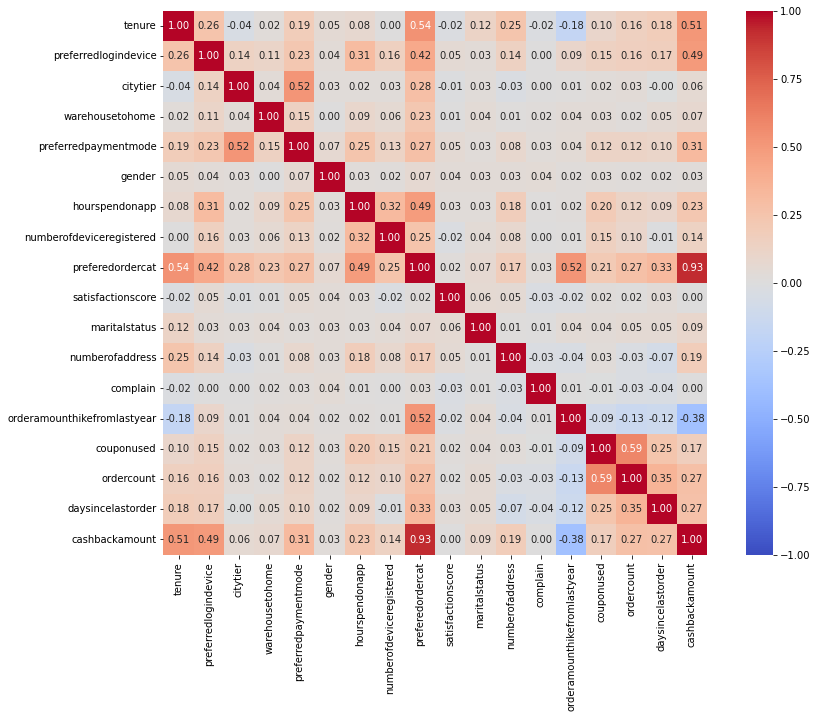

In [247]:
fig, ax = plt.subplots(figsize = (14, 10))
r = associations(features, ax = ax, cmap = 'coolwarm')

In [248]:
df = df.drop(['preferedordercat'], axis = 1)

**Split the train and test data**

In [249]:
X = df.drop('churn', axis = 1) 

In [250]:
y = df['churn']

To divide X and y into the train and test datasets we need to train the model we will use the train_test_split( ) function from scikit-learn. We will assign 30% of the data to the test groups using the argument test_size = 0.3, and we will use the stratify = y option to ensure the target variable is present in the test and train data in equal proportions. The random_state = 42 argument means we get reproducible results each time we run the code, rather than a random mix, which may give us different results.

In [251]:
from sklearn.model_selection import train_test_split

In [252]:
# Isolate X and y variables, and perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

**Create a model pipeline**

Next, we will create a model pipeline. This will handle the encoding of our data using the ColumnTransformer( ) feature. This also scales the data before we pass it to the model.

I have used the SMOTEENN to better handle class imbalance.

In [253]:
import time
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [254]:
def get_pipeline(X, model):

    numeric_columns = list(X.select_dtypes(exclude = ['object']).columns.values.tolist())    
    categorical_columns = list(X.select_dtypes(include = ['object']).columns.values.tolist())
    numeric_pipeline = SimpleImputer(strategy = 'median')
    categorical_pipeline = OneHotEncoder(drop = 'if_binary', sparse = False, handle_unknown = 'ignore')
    
    preprocessor = ColumnTransformer(transformers = [('numeric', numeric_pipeline, numeric_columns), ('categorical', categorical_pipeline, categorical_columns)], remainder = 'passthrough')

    bundled_pipeline = imbpipeline(steps = [('preprocessor', preprocessor),
                                            ('smote', SMOTEENN(random_state = 42)),
                                            ('scaler', RobustScaler()),
                                            ('model', model)])
    return bundled_pipeline

**Select the best model**

Rather than simply selecting a single model, or repeating our code manually on a range of models, we can create another function to automatically test a wide range of possible models to determine the best one for our needs. To do this we first create a dictionary containing some a selection of base classifiers, including XGBoost, Random Forest, Decision Tree, SVC, and a Bernoulli Naive Bayes among others.

We will create a Pandas dataframe into which we will store the data. Then we will loop over each of the models, fit it using the X_train and y_train data, then generate predictions from X_test and calculate the mean ROC/AUC score from 10 rounds of cross-validation. That will give us the ROC/AUC score for the X_test data, plus the average ROC/AUC score for the training data set.

In [255]:
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

In [256]:
def select_model(X, y, pipeline = None):

  classifiers = {}
  classifiers.update({'DummyClassifier': DummyClassifier(strategy = 'most_frequent', random_state = 42)})
  classifiers.update({'XGBClassifier': XGBClassifier(random_state = 42)})
  classifiers.update({'XGBRFClassifier': XGBRFClassifier(random_state = 42)})
  classifiers.update({'LGBMClassifier': LGBMClassifier(random_state = 42)})
  classifiers.update({'RandomForestClassifier': RandomForestClassifier(random_state = 42)})
  classifiers.update({'DecisionTreeClassifier': DecisionTreeClassifier(random_state = 42)})
  classifiers.update({'ExtraTreeClassifier': ExtraTreesClassifier(random_state = 42)})
  classifiers.update({'GradientBoostingClassifier': GradientBoostingClassifier(random_state = 42)})    
  classifiers.update({'BaggingClassifier': BaggingClassifier(random_state = 42)})
  classifiers.update({'AdaBoostClassifier': AdaBoostClassifier(random_state = 42)})
  classifiers.update({'HistGradientBoostingClassifier': HistGradientBoostingClassifier(random_state = 42)})
  classifiers.update({'KNeighborsClassifier': KNeighborsClassifier()})
  classifiers.update({'SGDClassifier': SGDClassifier(random_state = 42)})
  classifiers.update({'BaggingClassifier': BaggingClassifier(random_state = 42)})
  classifiers.update({'BernoulliNB': BernoulliNB()})
  classifiers.update({'SVC': SVC(random_state = 42)})
  classifiers.update({'CatBoostClassifier': CatBoostClassifier(silent = True, random_state = 42)})

  df_models = pd.DataFrame(columns = ['model', 'run_time', 'roc_auc_cv', 'roc_auc'])

  for key in classifiers:

      print('*', key)

      start_time = time.time()
      
      pipeline = get_pipeline(X_train, classifiers[key])

      cv = cross_val_score(pipeline, X, y, cv = 10, scoring = 'roc_auc', n_jobs = -1)

      pipeline.fit(X_train, y_train)
      y_pred = pipeline.predict(X_test)

      row = {'model': key,
             'run_time': format(round((time.time() - start_time) / 60, 2)),
             'roc_auc_cv': cv.mean(),
             'roc_auc': roc_auc_score(y_test, y_pred)}

      df_models = df_models.append(row, ignore_index = True)

  df_models = df_models.sort_values(by = 'roc_auc', ascending = False)
      
  return df_models

In [257]:
models = select_model(X_train, y_train)

* DummyClassifier
* XGBClassifier
* XGBRFClassifier
* LGBMClassifier
* RandomForestClassifier
* DecisionTreeClassifier
* ExtraTreeClassifier
* GradientBoostingClassifier
* BaggingClassifier
* AdaBoostClassifier
* HistGradientBoostingClassifier
* KNeighborsClassifier
* SGDClassifier
* BernoulliNB
* SVC
* CatBoostClassifier


In [258]:
models.head(10)

,model,run_time,roc_auc_cv,roc_auc
3,LGBMClassifier,0.23,0.945850,0.919687
10,HistGradientBoostingClassifier,0.25,0.945575,0.913675
15,CatBoostClassifier,2.44,0.948809,0.909086
6,ExtraTreeClassifier,0.2,0.962005,0.887379
4,RandomForestClassifier,0.23,0.947882,0.883015
14,SVC,0.25,0.897191,0.847315
5,DecisionTreeClassifier,0.13,0.835060,0.846585
8,BaggingClassifier,0.16,0.923426,0.844582
7,GradientBoostingClassifier,0.35,0.912237,0.841603
1,XGBClassifier,0.21,0.910707,0.829673


**Assessing performance**

When it comes to assessing models, there’s more to it than simply picking the one with the best score. It’s where the model that goes wrong that often matters.

In [259]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [260]:
classifiers = {'LGBMClassifier': LGBMClassifier(random_state = 42), 
               'HistGradientBoostingClassifier': HistGradientBoostingClassifier(random_state = 42)}

df_models = pd.DataFrame(columns = ['model', 'precision', 'recall', 'roc_auc'])

for key in classifiers:

    print('*', key)
      
    pipeline = get_pipeline(X_train, classifiers[key])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    row = {'model': key,
           'precision': round(precision, 2),
           'recall': round(recall, 2),
           'roc_auc': round(roc_auc, 2)}

    df_models = df_models.append(row, ignore_index = True)

* LGBMClassifier
* HistGradientBoostingClassifier


In [261]:
df_models.sort_values(by = 'roc_auc', ascending = False).head()

,model,precision,recall,roc_auc
0,LGBMClassifier,0.72,0.91,0.92
1,HistGradientBoostingClassifier,0.70,0.90,0.91


**Fit the best model**

Finally, we can take our best model - the LGBMClassifier - and fit the data on this. To do this step, we will first define our selected model, then we will pass its configuration to get_pipeline( ) with our training data. Then, we will fit( ) the training data and use predict( ) to return our predictions from the newly trained model.

In [262]:
selected_model = LGBMClassifier(random_state = 42)
bundled_pipeline = get_pipeline(X_train, selected_model)
bundled_pipeline.fit(X_train, y_train)
y_pred = bundled_pipeline.predict(X_test)

**Examine the predictions**

To examine how well the model performed in a little more detail we can make use of the classification_report( ). The classification report shows us the precision, recall, and F1 score for our predictions.




In [263]:
from sklearn.metrics import classification_report

In [264]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1405
           1       0.72      0.91      0.80       284

    accuracy                           0.92      1689
   macro avg       0.85      0.92      0.88      1689
weighted avg       0.94      0.92      0.93      1689



Let’s unpack those results a little bit…

**Recall**


A churn class recall of 0.91 means that the model was able to catch 91% of the actual churn cases. This is the measure we really care about, because we want to miss as few of the true churn cases as possible.

**Precision**

Precision of the churn class measures how often the model catches an actual churn case, while also factoring in how often it misclassifies a non-churn case as a churn case. In this case, a churn precision of 0.72 is not a problem because there are no significant consequences of identifying a customer as a churn risk when she isn’t.

**F1 score**

The F1 score is the harmonic mean of precision and recall. It helps give us a balanced idea of how the model is performing on the churn class. In this case a churn class F1 score of 0.80 is pretty good. 